In [1]:
import sys
sys.path.append("/sps/lsst/users/ebarroso/crow")
import crow
from crow.deltasigma import *

## Testing Shear implementation in deltasigma.py

In [2]:
import pyccl as ccl
hmf = ccl.halos.MassFuncTinker08(mass_def="200c")

cl_delta_sigma = ClusterDeltaSigma((12,15), (0.1,1.2), hmf, True, 4.0)
cosmo = ccl.Cosmology(
    Omega_c=0.2607,      # Cold dark matter density
    Omega_b=0.04897,     # Baryon density
    h=0.6766,            # Hubble parameter
    sigma8=0.8102,       # Matter fluctuation amplitude
    n_s=0.9665,          # Spectral index
)
cl_delta_sigma._cosmo = cosmo

cl_reduced_shear = ClusterDeltaSigma((12,15), (0.1,1.2), hmf, False, 4.0)

cl_reduced_shear._cosmo = cosmo

In [3]:
ds_val = cl_delta_sigma.delta_sigma([13], [1.2], 3.0)
print(ds_val)

gt_val = cl_reduced_shear.delta_sigma([13], [1.2], 3.0)
print(gt_val)

[1.13451921e+12]
[0.00027905]


## Values with interpolated Beta

In [4]:
gt_val = cl_reduced_shear.delta_sigma([13], [1.2], 3.0, use_beta_interp=True)
print(gt_val)
cl_reduced_shear.beta_zbin_cl_edges = [0.2, 0.4]
cl_reduced_shear.beta_interp = None
gt_val = cl_reduced_shear.delta_sigma([13], [1.2], 3.0, use_beta_interp= True)
print(gt_val)

Warning, no redshift bin for beta estimation, using integration values (0.1, 1.2) instead
[0.00027905]
[0.00045063]


## Test implementation on the recipe

In [5]:
from crow.recipes.murata_binned_spec_z_deltasigma import MurataBinnedSpecZDeltaSigmaRecipe
from crow.mass_proxy import MurataBinned
from crow.kernel import SpectroscopicRedshift
from firecrown.models.cluster import ClusterProperty
import time

pivot_mass, pivot_redshift = 14.625862906, 0.6
mass_distribution = MurataBinned(pivot_mass, pivot_redshift)
redshift_distribution = SpectroscopicRedshift()

def run_recipe(label, is_delta_sigma=False, use_beta_interp=False):
    print(f"\n{label} Starts here\n{'-'*50}")
    average_on = ClusterProperty.NONE
    average_on |= ClusterProperty.DELTASIGMA
    average_on |= ClusterProperty.SHEAR
    recipe = MurataBinnedSpecZDeltaSigmaRecipe(
        hmf=hmf,
        redshift_distribution=redshift_distribution,
        mass_distribution=mass_distribution,
        is_delta_sigma=is_delta_sigma,
        use_beta_interp=use_beta_interp
    )
    recipe.cluster_theory._cosmo = cosmo

    t0 = time.time()
    val1 = recipe.evaluate_theory_prediction((1.1, 1.2), (1, 2), 1.0, 440, average_on)
    t1 = time.time()
    print(f"Eval 1: {val1:.3e} | Time: {t1-t0:.4f} s")

    t2 = time.time()
    val2 = recipe.evaluate_theory_prediction((0.2, 0.31), (0.86, 1.0), 4.0, 440, average_on)
    t3 = time.time()
    print(f"Eval 2: {val2:.3e} | Time: {t3-t2:.4f} s")

    counts = recipe.evaluate_theory_prediction_counts((0.2, 0.31), (0.86, 1.0), 440)
    print(f"Counts: {counts:.3e}")

# Run different scenarios
run_recipe("Delta Sigma", is_delta_sigma=True)
run_recipe("Tangential Shear", is_delta_sigma=False)
run_recipe("Tangential Shear with Interpolation", is_delta_sigma=False, use_beta_interp=True)



Delta Sigma Starts here
--------------------------------------------------
Eval 1: 5.718e+29 | Time: 0.7424 s
Eval 2: 6.872e+27 | Time: 0.4087 s
Counts: 2.658e+02

Tangential Shear Starts here
--------------------------------------------------
Eval 1: 3.743e-02 | Time: 4.0071 s
Eval 2: 7.911e-04 | Time: 13.8423 s
Counts: 2.658e+02

Tangential Shear with Interpolation Starts here
--------------------------------------------------
Eval 1: 3.743e-02 | Time: 0.4501 s
Eval 2: 7.911e-04 | Time: 0.4899 s
Counts: 2.658e+02


### Interpolation test

0.1 0.6


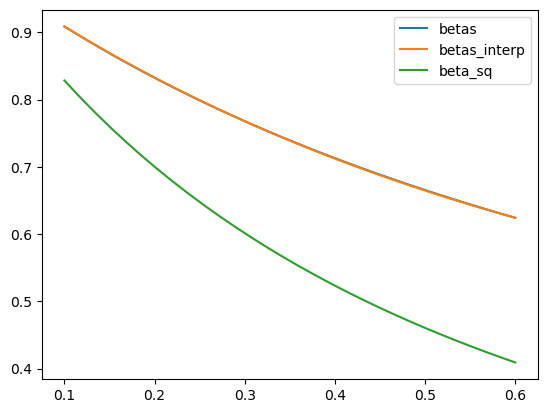

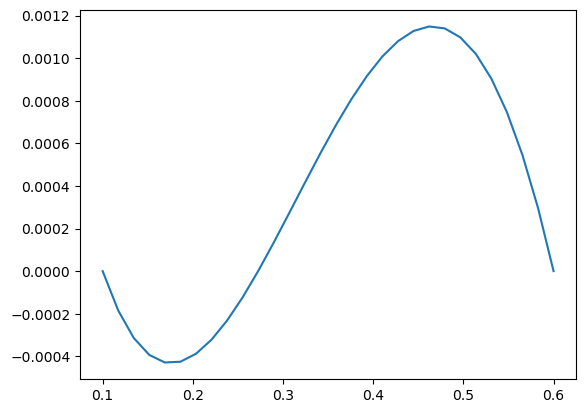

0.2111111111111111 0.7111111111111111


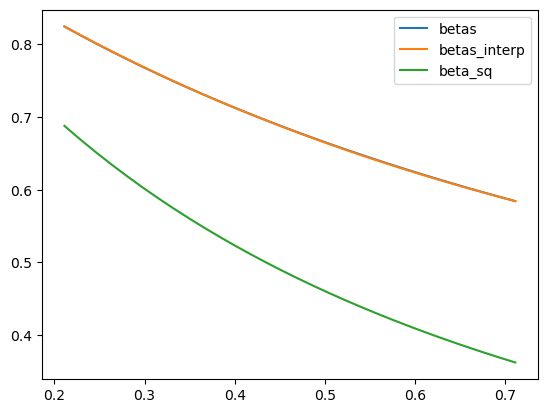

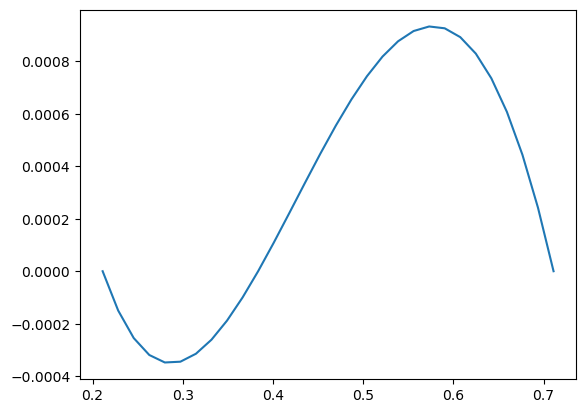

0.3222222222222222 0.8222222222222222


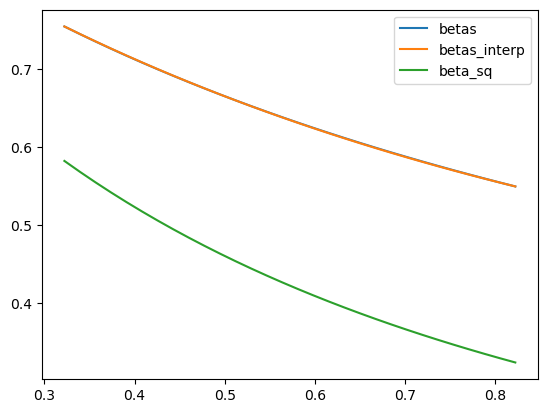

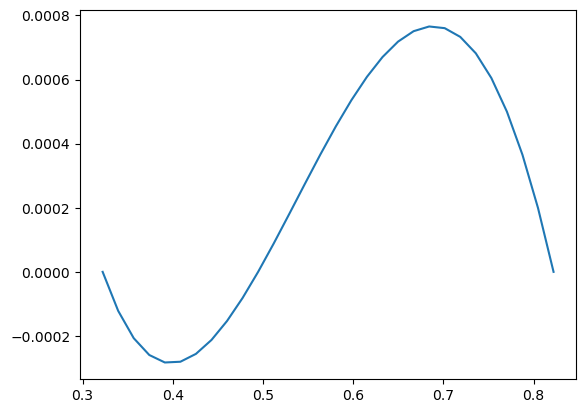

0.43333333333333335 0.9333333333333333


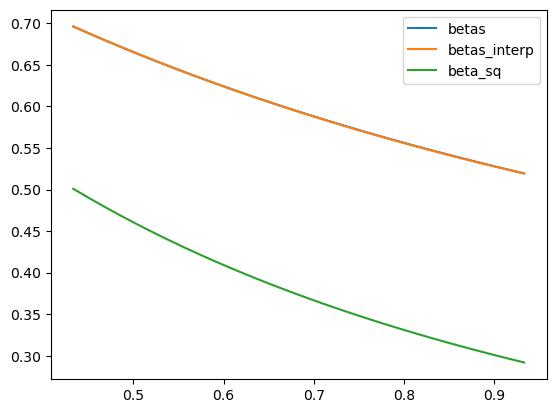

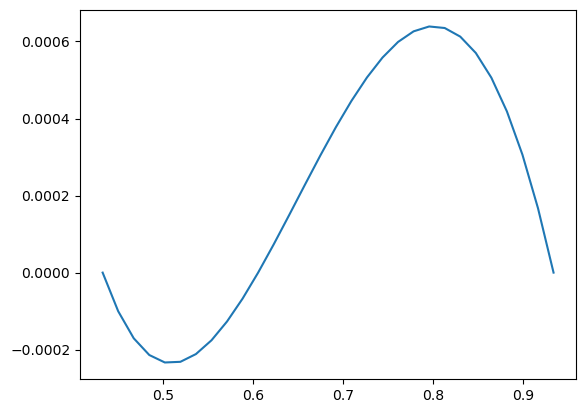

0.5444444444444444 1.0444444444444443


0.6555555555555556 1.1555555555555554


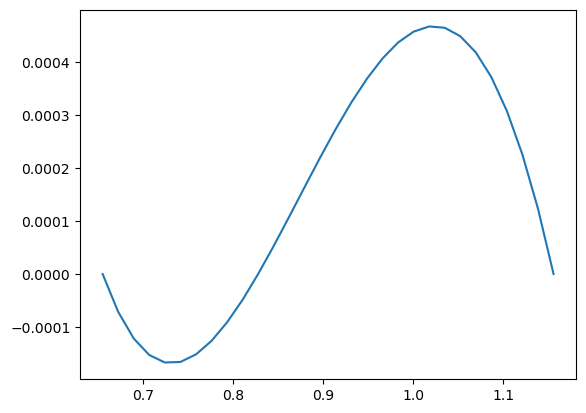

0.7666666666666666 1.2666666666666666


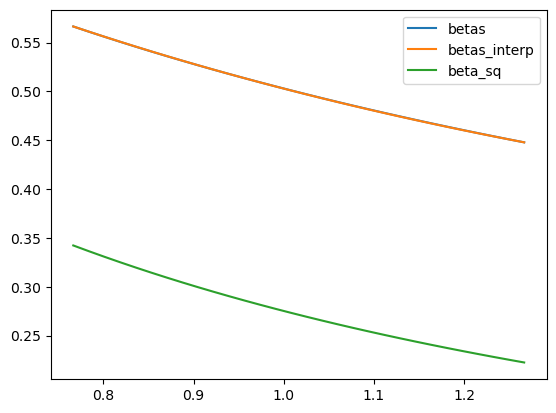

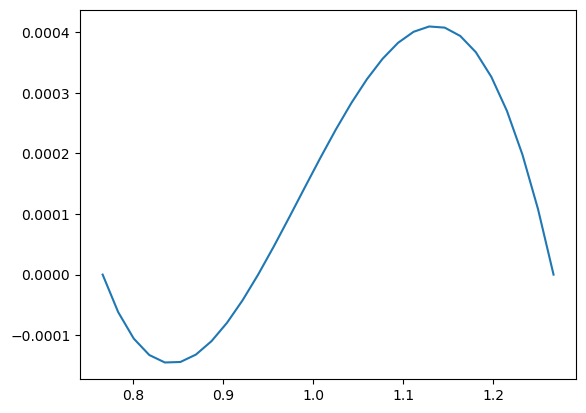

0.8777777777777777 1.3777777777777778


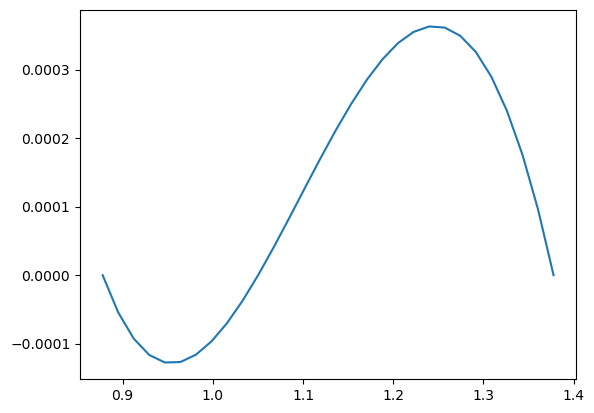

0.9888888888888888 1.488888888888889


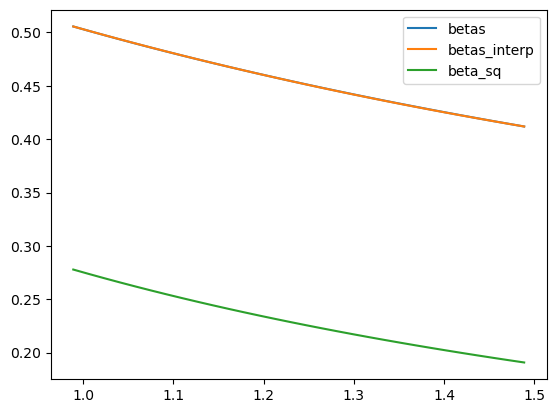

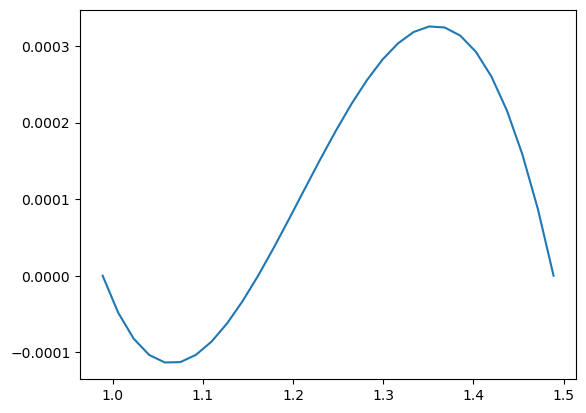

1.1 1.6


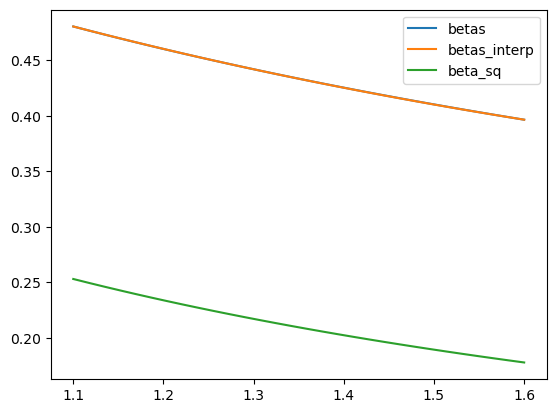

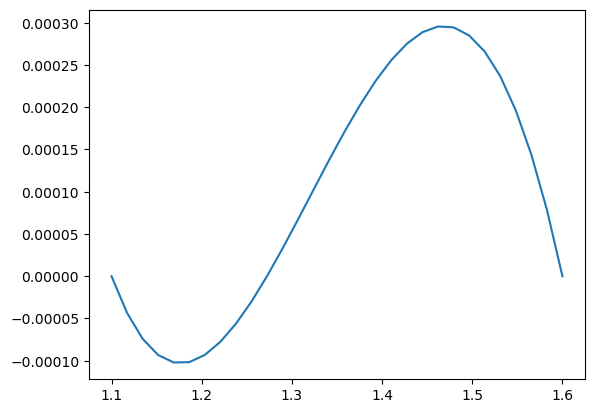

In [6]:
import clmm
import numpy as np
import matplotlib.pyplot as plt
clmm_cosmo = clmm.Cosmology()
clmm_cosmo._init_from_cosmo(cosmo)
from scipy.interpolate import interp1d
bins = [(bin1, bin1 + 0.5) for bin1 in np.linspace(0.1, 1.1, 10)]
z_inf = 10
zmax = 5.0
for bin1,bin2 in bins:
    print(bin1,bin2)
    z_cls = np.linspace(bin1, bin2, 30)
    beta_list = []
    beta_sq_list = []
    for z_cl in z_cls:
        beta_smean = clmm.utils.compute_beta_s_mean_from_distribution(z_cl, z_inf, clmm_cosmo, zmax=zmax, delta_z_cut=0.3, zmin=None, z_distrib_func=None)
        beta_sqmean = clmm.utils.compute_beta_s_square_mean_from_distribution(z_cl, z_inf, clmm_cosmo, zmax=zmax, delta_z_cut=0.3, zmin=None, z_distrib_func=None)
        beta_list.append(beta_smean)
        beta_sq_list.append(beta_sqmean)
    log_beta_interp = interp1d(
    [z_cls[0], z_cls[10], z_cls[-1]],
    np.log([beta_list[0], beta_list[10], beta_list[-1]]),
    kind='quadratic',
    fill_value='extrapolate'# or 'cubic', 'quadratic' for smoother
)
    interpolated = log_beta_interp(z_cls)   #np.interp(z_cls,[z_cls[0], z_cls[-1]],[np.log(beta_list[0]), np.log(beta_list[-1])])
    # beta_sqmean[-1] beta_sqmean[0]
    plt.plot(z_cls, beta_list, label='betas')
    plt.plot(z_cls, np.exp(interpolated), label='betas_interp')
    plt.plot(z_cls, beta_sq_list, label = 'beta_sq')
    plt.legend()
    plt.show()
    plt.plot(z_cls, 1 - np.exp(interpolated)/np.array(beta_list))
    plt.show()